# Panorama: A robust pangenome-based method for predicting and comparing biological systems across species

Jérôme Arnoux$^{1,*}$, Jean Mainguy$^{1}$, Laura Bry$^{1}$, Quentin Fernandez de Grado$^{1,2}$, Vallenet David$^{1}$, Alexandra Calteau$^{1}$,


1. LABGeM, Genomics Metabolics, CEA, Genoscope, Institut François Jacob, Université d’Évry, Université Paris-Saclay, CNRS
2. Bla

*Corresponding author*:
* jarnoux@genoscope.cns.fr

# Abstrasct

Over the last decade, the expansion in the number of available genomes has profoundly transformed the study of genetic diversity, evolution, and ecological adaptation in prokaryotes. However, traditional bioinformatic approaches based on the analysis of individual genomes are showing their limitations when faced with the sheer scale of the data. To overcome these constraints, the concept of pangenome has emerged, offering a comprehensive framework to capture the full genetic repertoire of a species. In this study, we present PANORAMA, an innovative pangenomic tool designed to exploit pangenome graphs and enable them to be annotated and compared in order to explore the genomic diversity of several species. Based on the PPanGGOLiN software suite, PANORAMA integrates advanced methods for rule-based prediction of macromolecular systems and comparative analysis of conserved features between different pangenomes, such as hotspots of insertion. We illustrate the use of PANORAMA on a Pseudomonas aeruginosa dataset, evaluating its performance against reference defense system prediction tools such as PADLOC and DefenseFinder. The analysis was then extended to a larger set including four species of Enterobacteriaceae ($>$6,000 genomes), demonstrating PANORAMA's ability to annotate, compare and explore the diversity and distribution of biological systems across multiple species. This work provides new methods for the large-scale comparative study of microbial genomes and underlines the relevance of pangenome approaches in deciphering their evolutionary dynamics. PANORAMA is freely available and accessible through: \url{https://github.com/labgem/PANORAMA}

**Keywords:**

Pangenome, Comparative genomics, Bacterial defense systems, Pseudomonas aeruginosa, Enterobacteriaceae, Bioinformatics.

# Introduction

This Jupyter notebook will be organized into three parts. The first part (Results) will generate the raw figures presented in the article. The second (Supplementary) part will generate the additional figures. The last part (DATA) will contain the commands used to create the dataset, the pangenomes, and to redo the analyses with PANORAMA. These data are also available directly in the Zenodo repository linked to the publication. It is therefore not necessary to reproduce the data.

# Results

## Define constant and load data


In [1]:
from pathlib import Path
from multiprocessing import cpu_count

# Determine the number of available CPUs for multiprocessing
CPU_COUNT = cpu_count()
P_AERUGINOSA = Path("DATA/P.aeruginosa/")
PANORAMA_PADLOC_RES = P_AERUGINOSA / "PANORAMA/padloc/"
PADLOC_RES = P_AERUGINOSA / "PADLOC/"
PANORAMA_DFINDER_RES = P_AERUGINOSA / "PANORAMA/dfinder/"
DFINDER_RES = P_AERUGINOSA / "DFINDER/"
GF2GENE = P_AERUGINOSA / "gene_families.tsv"
LOCUS2PROTID = P_AERUGINOSA / "locus2protID.tsv"
OUTPUT = Path("figures")

In [2]:
from multiprocessing import Process, Manager
from sources.dev_utils import get_tool_systems, merge_results
from sources.read_results import (load_gene_families, load_locus_tags, load_padloc_results, load_dfinder_results,
                                  load_panorama_results, read_panorama_pangenome_systems)

# Create a manager to coordinate shared data
manager = Manager()
return_dict = manager.dict()

# Starting the gene family and locus tag loading processes
p1 = Process(target=load_gene_families, args=(GF2GENE, return_dict))
p2 = Process(target=load_locus_tags, args=(LOCUS2PROTID, return_dict))

# Start and join first two processes to ensure dependent tasks can proceed
p1.start()
p2.start()
p1.join()
p2.join()

# Retrieve necessary data from the return dictionary
gene2family = return_dict['gene2family']
locus2protID = return_dict['locus2protID']

# Starting the result loading processes (dependent on gene2family and locus2protID)
p3 = Process(target=load_padloc_results, args=(PADLOC_RES, gene2family, locus2protID, return_dict, 0))
p4 = Process(target=load_panorama_results, args=(PANORAMA_PADLOC_RES / "projection", return_dict, "padloc", 1))
p5 = Process(target=load_dfinder_results, args=(DFINDER_RES, gene2family, locus2protID, return_dict, 2))
p6 = Process(target=load_panorama_results, args=(PANORAMA_DFINDER_RES / "projection", return_dict, "dfinder", 3))

# Start the remaining processes
p3.start()
p4.start()
p5.start()
p6.start()

# Wait for all processes to complete
p3.join()
p4.join()
p5.join()
p6.join()

# Retrieving results from the shared dictionary
fam2size = return_dict['fam2size']

# Aggregating counts and annotations
count_dict = {
    "Padloc": return_dict['padloc_count'],
    "Panorama_padloc": return_dict['panorama_padloc_count'],
    "Dfinder": return_dict['dfinder_count'],
    "Panorama_dfinder": return_dict['panorama_dfinder_count']
}

fam2annot = {
    "Padloc": return_dict['padloc_fam_annot'],
    "Panorama_padloc": return_dict['panorama_padloc_fam_annot'],
    "Dfinder": return_dict['dfinder_fam_annot'],
    "Panorama_dfinder": return_dict['panorama_dfinder_fam_annot']
}

systems2partitions = {
    "Padloc": return_dict['padloc_systems2partitions'],
    "Dfinder": return_dict['dfinder_systems2partitions']
}

name2systems = {
    "Padloc": return_dict['padloc_name2systems'],
    "Dfinder": return_dict['dfinder_name2systems']
}

# Retrieve results for each method
padloc_res = return_dict['padloc_res']
dfinder_res = return_dict['dfinder_res']
panorama_padloc_res = return_dict['panorama_padloc_res']
panorama_dfinder_res = return_dict['panorama_dfinder_res']

# Extract systems from PADLOC and DefenseFinder
padloc_systems = get_tool_systems(padloc_res)
dfinder_systems = get_tool_systems(dfinder_res)

# Extract systems from the panorama dictionaries
panorama_systems_padloc = read_panorama_pangenome_systems(PANORAMA_PADLOC_RES / "systems.tsv")
panorama_systems_dfinder = read_panorama_pangenome_systems(PANORAMA_DFINDER_RES / "systems.tsv")
# Combine the panorama systems
dfinder_systems = merge_results(dfinder_systems, dfinder_systems, 1)
padloc_systems = merge_results(padloc_systems, padloc_systems, 1)
panorama_systems = merge_results(panorama_systems_padloc, panorama_systems_dfinder, 1)

5811655it [00:04, 1199408.04it/s]

Read Padloc results:   0%|          | 0/941 [00:00<?, ?it/s]

Read Defense Finder results:   0%|          | 0/941 [00:00<?, ?it/s]]


Read Padloc results:   1%|          | 10/941 [00:00<00:10, 87.76it/s]]

Read Panorama padloc results:   1%|          | 11/941 [00:00<00:09, 98.87it/s]


Read Padloc results:   2%|▏         | 21/941 [00:00<00:09, 96.83it/s]97.24it/s]

Read Panorama padloc results:   2%|▏         | 21/941 [00:00<00:09, 96.66it/s]


Read Panorama padloc results:   3%|▎         | 31/941 [00:00<00:09, 96.88it/s]

Read Defense Finder results:   5%|▌         | 48/941 [00:00<00:06, 143.93it/s]


Read Padloc results:   5%|▍         | 47/941 [00:00<00:08, 107.88it/s]1.88it/s]

Read Defense Finder results:   7%|▋         | 63/941 [00:00<00:06, 138.06it/s]


Read Panorama dfinder results:   5%|▍         | 45/939 [00:00<00:08, 102.53it/s]

Read Panorama padloc results:   6%|▌         | 53/941 [00:00<00:09, 91.34it/s] 


Read Panorama dfinder results

## System prediction benchmark

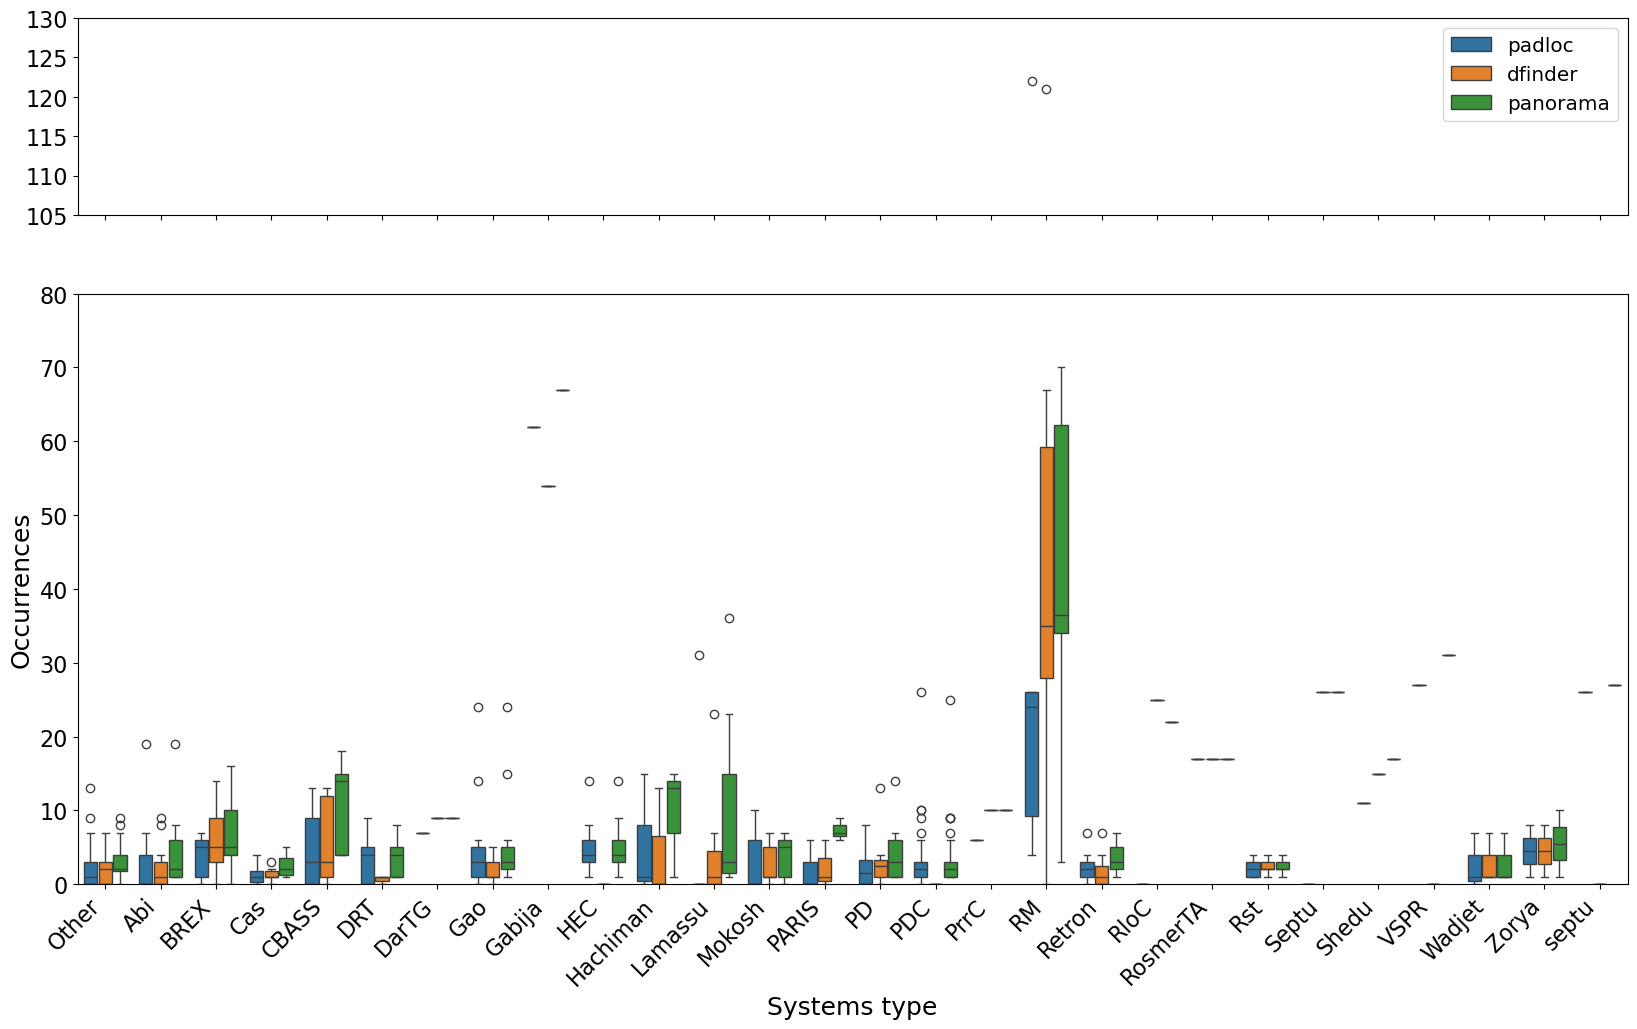


Number of pangenome systems: PADLOC 1068, DFINDER 868, PANORAMA 1520
PADLOC: 49, DFinder: 32, PANORAMA: 326, PADLOC & DFinder: 0, PANORAMA & PADLOC: 879, PANORAMA & DFinder: 653, ALL: 985


/home/jarnoux/anaconda3/envs/panorama_notebook/lib/python3.12/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


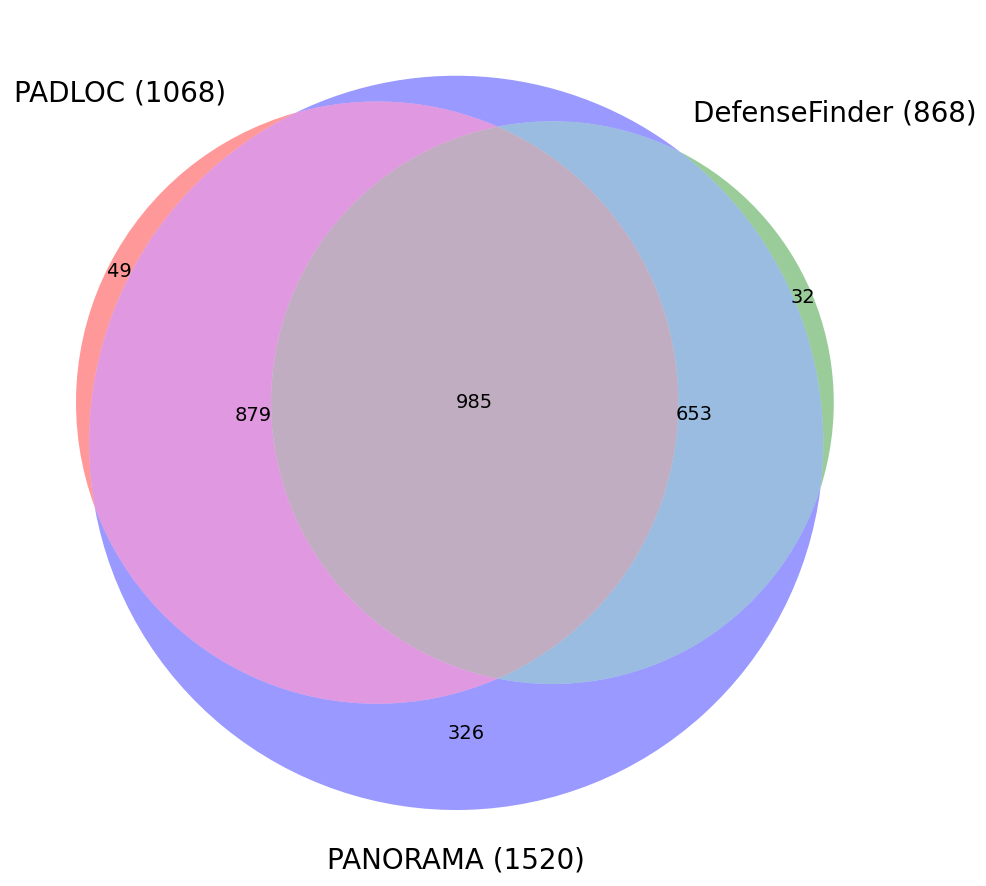

                                 Common M1  Common M2  % common  Specific M1  \
PADLOC (1068) & DFinder (868)        502.0      506.0     52.07        566.0   
PADLOC (1068) & PANORAMA (1064)     1031.0     1020.0     96.20         37.0   
DFinder (868) & PANORAMA (976)       843.0      829.0     90.67         25.0   

                                 Specific M2  
PADLOC (1068) & DFinder (868)          362.0  
PADLOC (1068) & PANORAMA (1064)         44.0  
DFinder (868) & PANORAMA (976)         147.0  


In [3]:
from sources.boxplot import gen_boxplot_pangenome
from sources.venn import plot_venn_diagram, count_system_similar

gen_boxplot_pangenome(padloc=padloc_systems, dfinder=dfinder_systems,
                      panorama=panorama_systems, output=OUTPUT / "boxplot_venn.png")
plot_venn_diagram(padloc_systems, dfinder_systems, panorama_systems, OUTPUT)

count_system_similar(padloc_systems, dfinder_systems, panorama_systems_padloc,
                     panorama_systems_dfinder, OUTPUT, 1)

**Fig. 2. Comparison of PANORAMA, PADLOC, and DefenseFinder system predictions at the pangenome
level.** PADLOC and Defense Finder predictions at the genome level were unified at the pangenome level by converting sets
of system genes to sets of gene families. (A) Venn diagram illustrating the overlap of system families predicted by the three
tools. (B) Boxplots displaying the distribution of system counts for each category, as predicted by the different tools.

## *Pseudomonas aeruginosa* defense system analysis

### System prediction and analysis

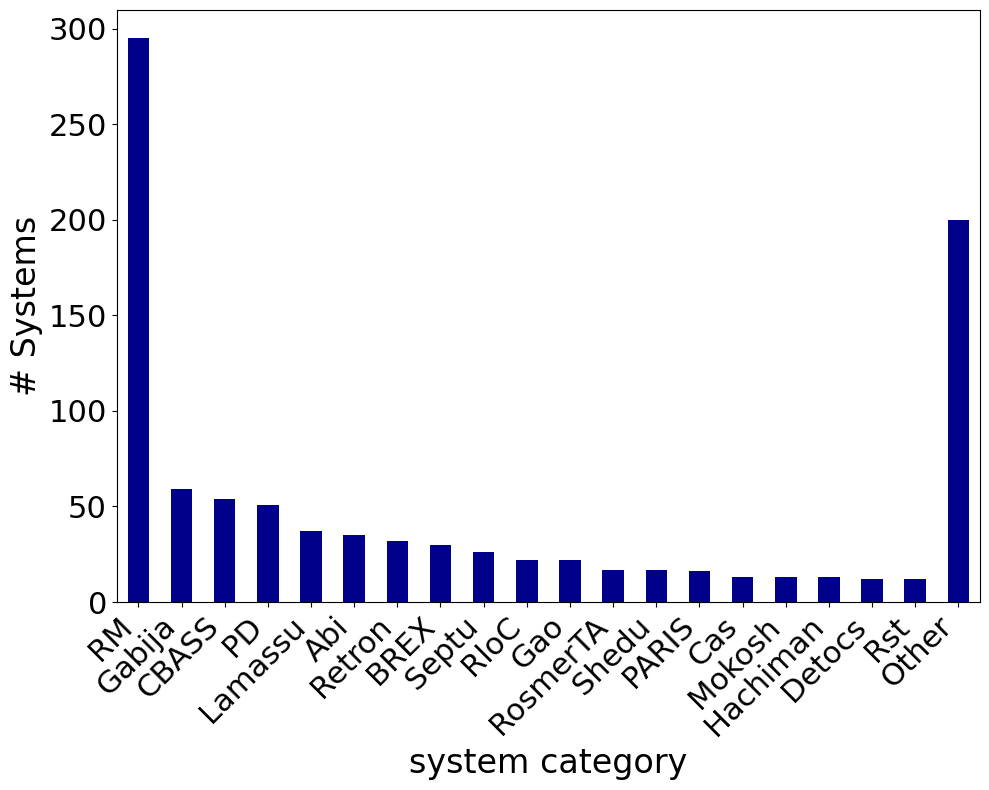

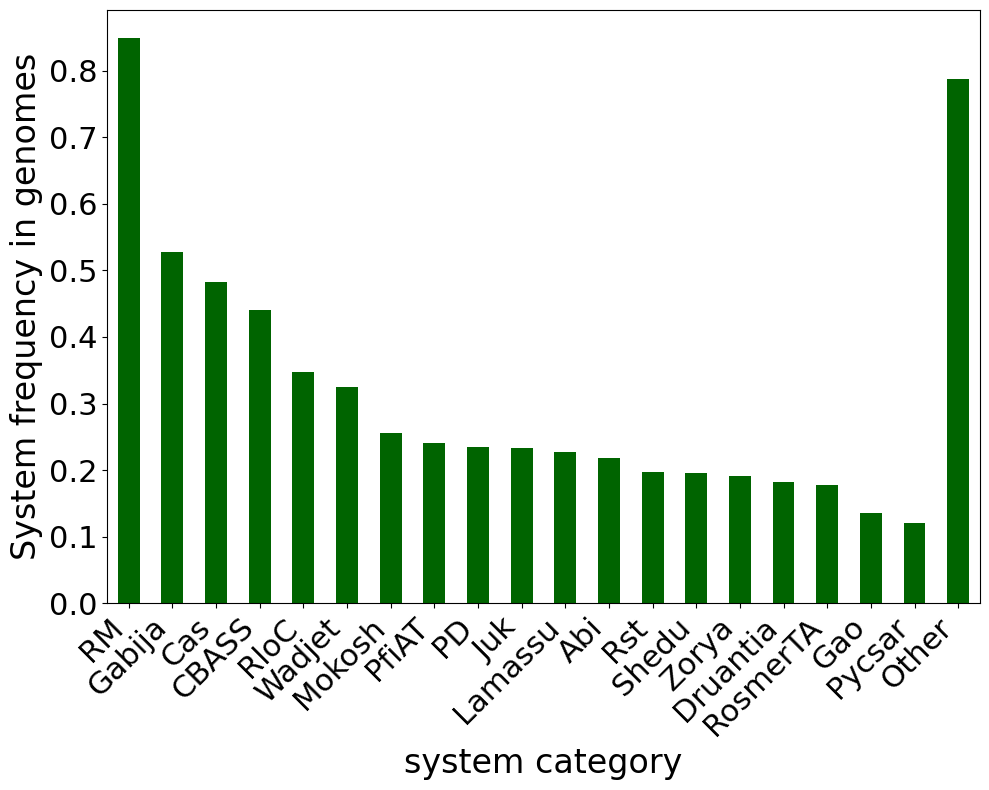

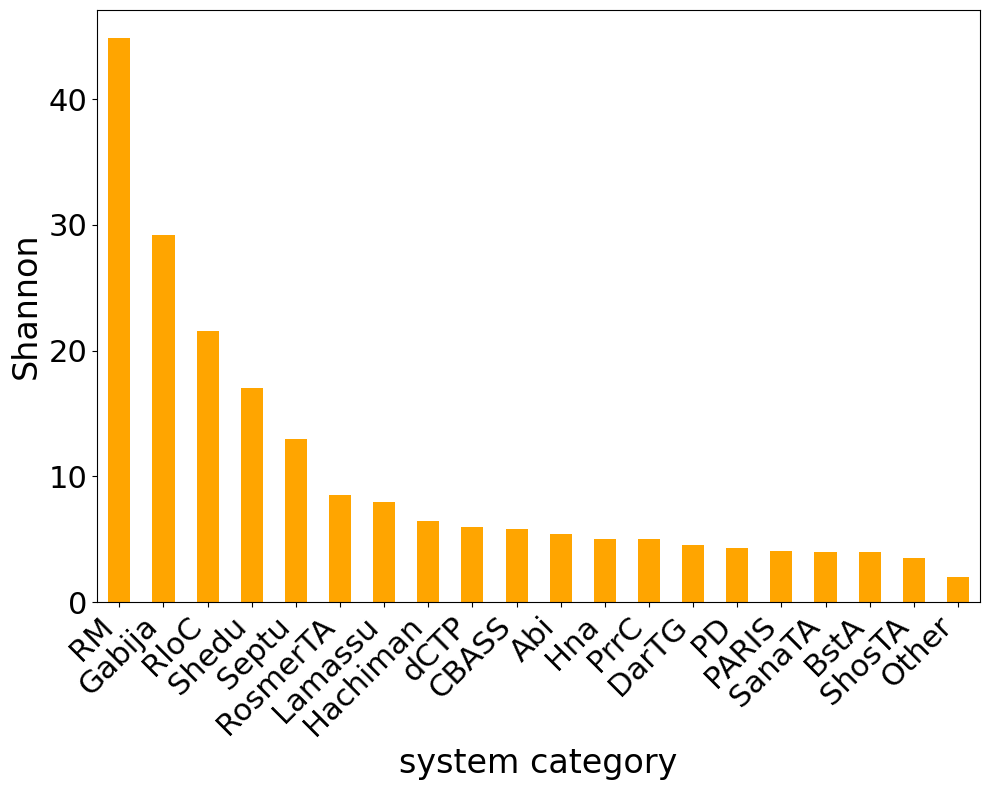

In [4]:
import pandas as pd
from sources.dev_utils import type2category
from sources.system_analyses import plot_occurrences_and_fraction

MODELS = Path("DATA/Models/defense-finder/models_list.tsv")
RESULTS = PANORAMA_DFINDER_RES / 'systems.tsv'
NB_GROUP = 20
NB_COLS = 55
NB_SPOTS = 7
FIGSIZE = (40, 20)
REVERSE = False
BAR_COLORS = ("darkblue", "darkgreen", "darkorange")

systems_data = pd.read_csv(RESULTS, sep='\t',
                           usecols=["system number", "system name", "organism",
                                    "model_GF", "partition", "spots"])

# Add the system category grouping
systems_data['system category'] = systems_data['system name'].map(type2category)

plot_occurrences_and_fraction(systems_data, MODELS, NB_GROUP, field='system category', output=OUTPUT,
                              kind="bar", reverse=REVERSE, bar_colors=BAR_COLORS)

**Fig. 3. System prediction metrics in *P. aeruginosa*.** Systems are grouped by categories on the x-axis and ordered
by decreasing values. Only the 19 highest-value system categories are displayed, with others grouped under the "Other"
category. (A) Number of systems found for each category in the pangenome. (B) Relative frequency of system categories in
genomes. (C) Shannon entropy of system categories.

### Defense islands and spots of insertion

Read projections: 100%|██████████| 939/939 [00:13<00:00, 67.89it/s]


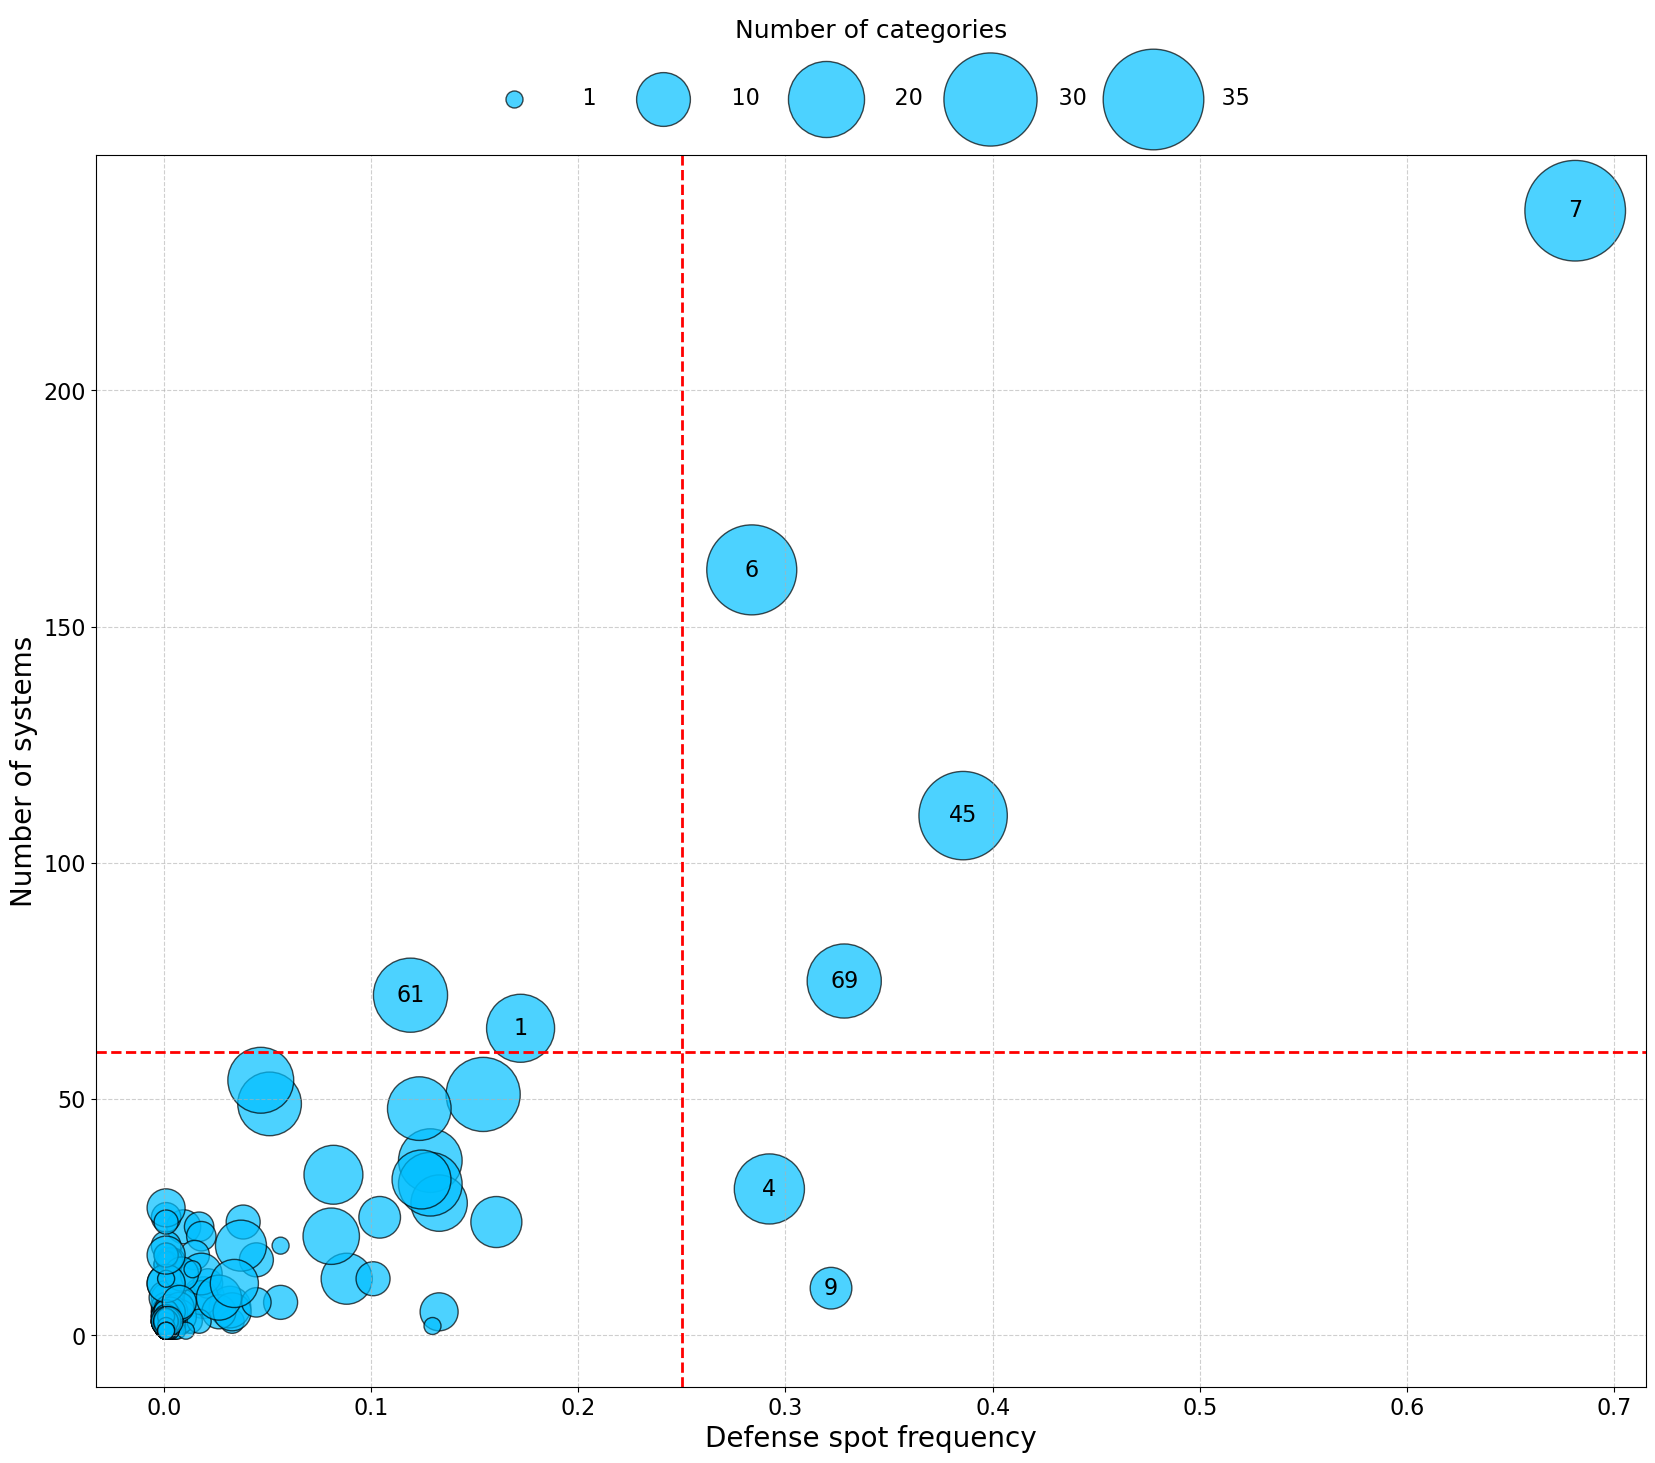

In [5]:
from sources.hotspot import get_spot2orgs, get_data_projection, scatter_plot

projection = PANORAMA_DFINDER_RES / "projection"
tables = P_AERUGINOSA / 'table'

number_genomes = sum(1 for _ in tables.glob("*.tsv"))
spot_to_orgs = get_spot2orgs(tables)
proj_df = get_data_projection(projection)

proj_df.to_csv(OUTPUT / "spot2sys_genomes.tsv", sep="\t", index=True)
scatter_plot(proj_df, spot_to_orgs, number_genomes, OUTPUT)


**Fig. 4. System diversity and defense spot frequency in *P. aeruginosa*.** This bubble plot displays the distribution
of defense spots identified by PANORAMA, based on their frequency in genomes (x-axis) and the total number of defense
systems identified within each spot at the pangenome level (y-axis). The size of the bubbles is proportional to the number
of distinct system categories represented in each spot (legend at top shows scale).

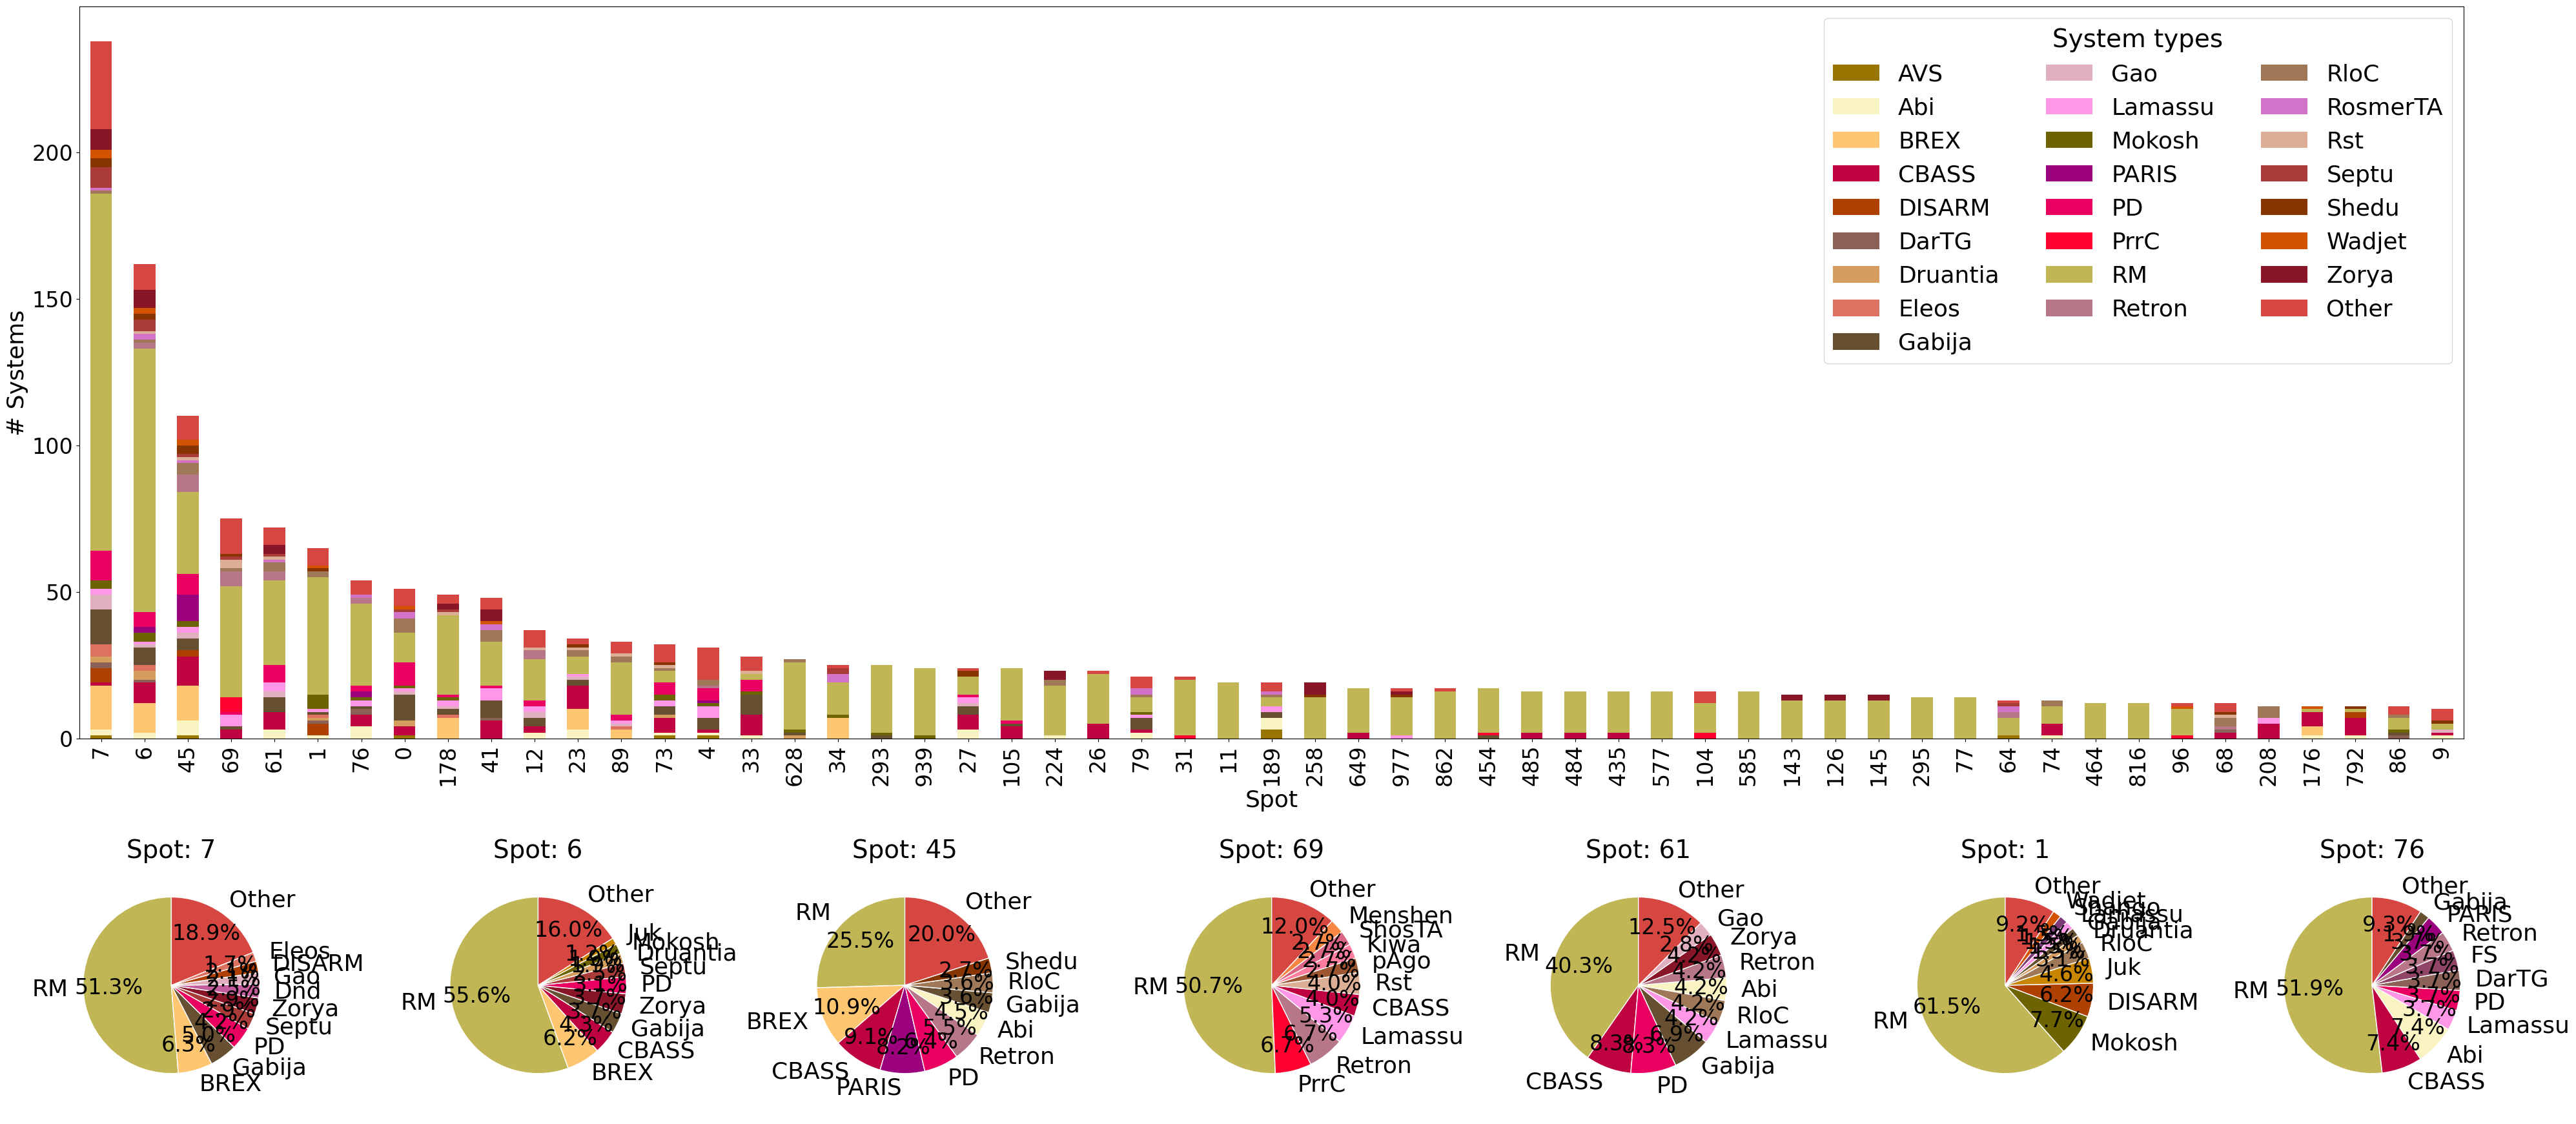

In [6]:
from sources.system_analyses import plot_spots_and_pies

plot_spots_and_pies(systems_data, field='system category', nb_cols=NB_COLS,
                    nb_spots=NB_SPOTS, output=OUTPUT, figsize=FIGSIZE)

**Fig. 5. Defense systems within insertion spots of the *P. aeruginosa* pangenome.** The bar plot (top) displays the
number of predicted defense systems in the P. aeruginosa pangenome for each insertion spot. Only spots with at least 10
systems are displayed. The pie charts (bottom) illustrate the system category composition for the six major insertion spots.

## Pangenome comparison of Enterobacteriaceae defense arsenal

### Get results and define constant

In [7]:
# Determine the number of available CPUs for multiprocessing
ENTEROBACTERIACEAE = Path("DATA/Enterobacteriaceae/")
C_FREUNDII = ENTEROBACTERIACEAE / "C.freundii/dfinder"
E_COLI = ENTEROBACTERIACEAE / "E.coli/dfinder"
K_PNEUMONIAE = ENTEROBACTERIACEAE / "K.pneumoniae/dfinder"
S_ENTERICA = ENTEROBACTERIACEAE / "S.enterica/dfinder"

### Defense system distribution in the four species

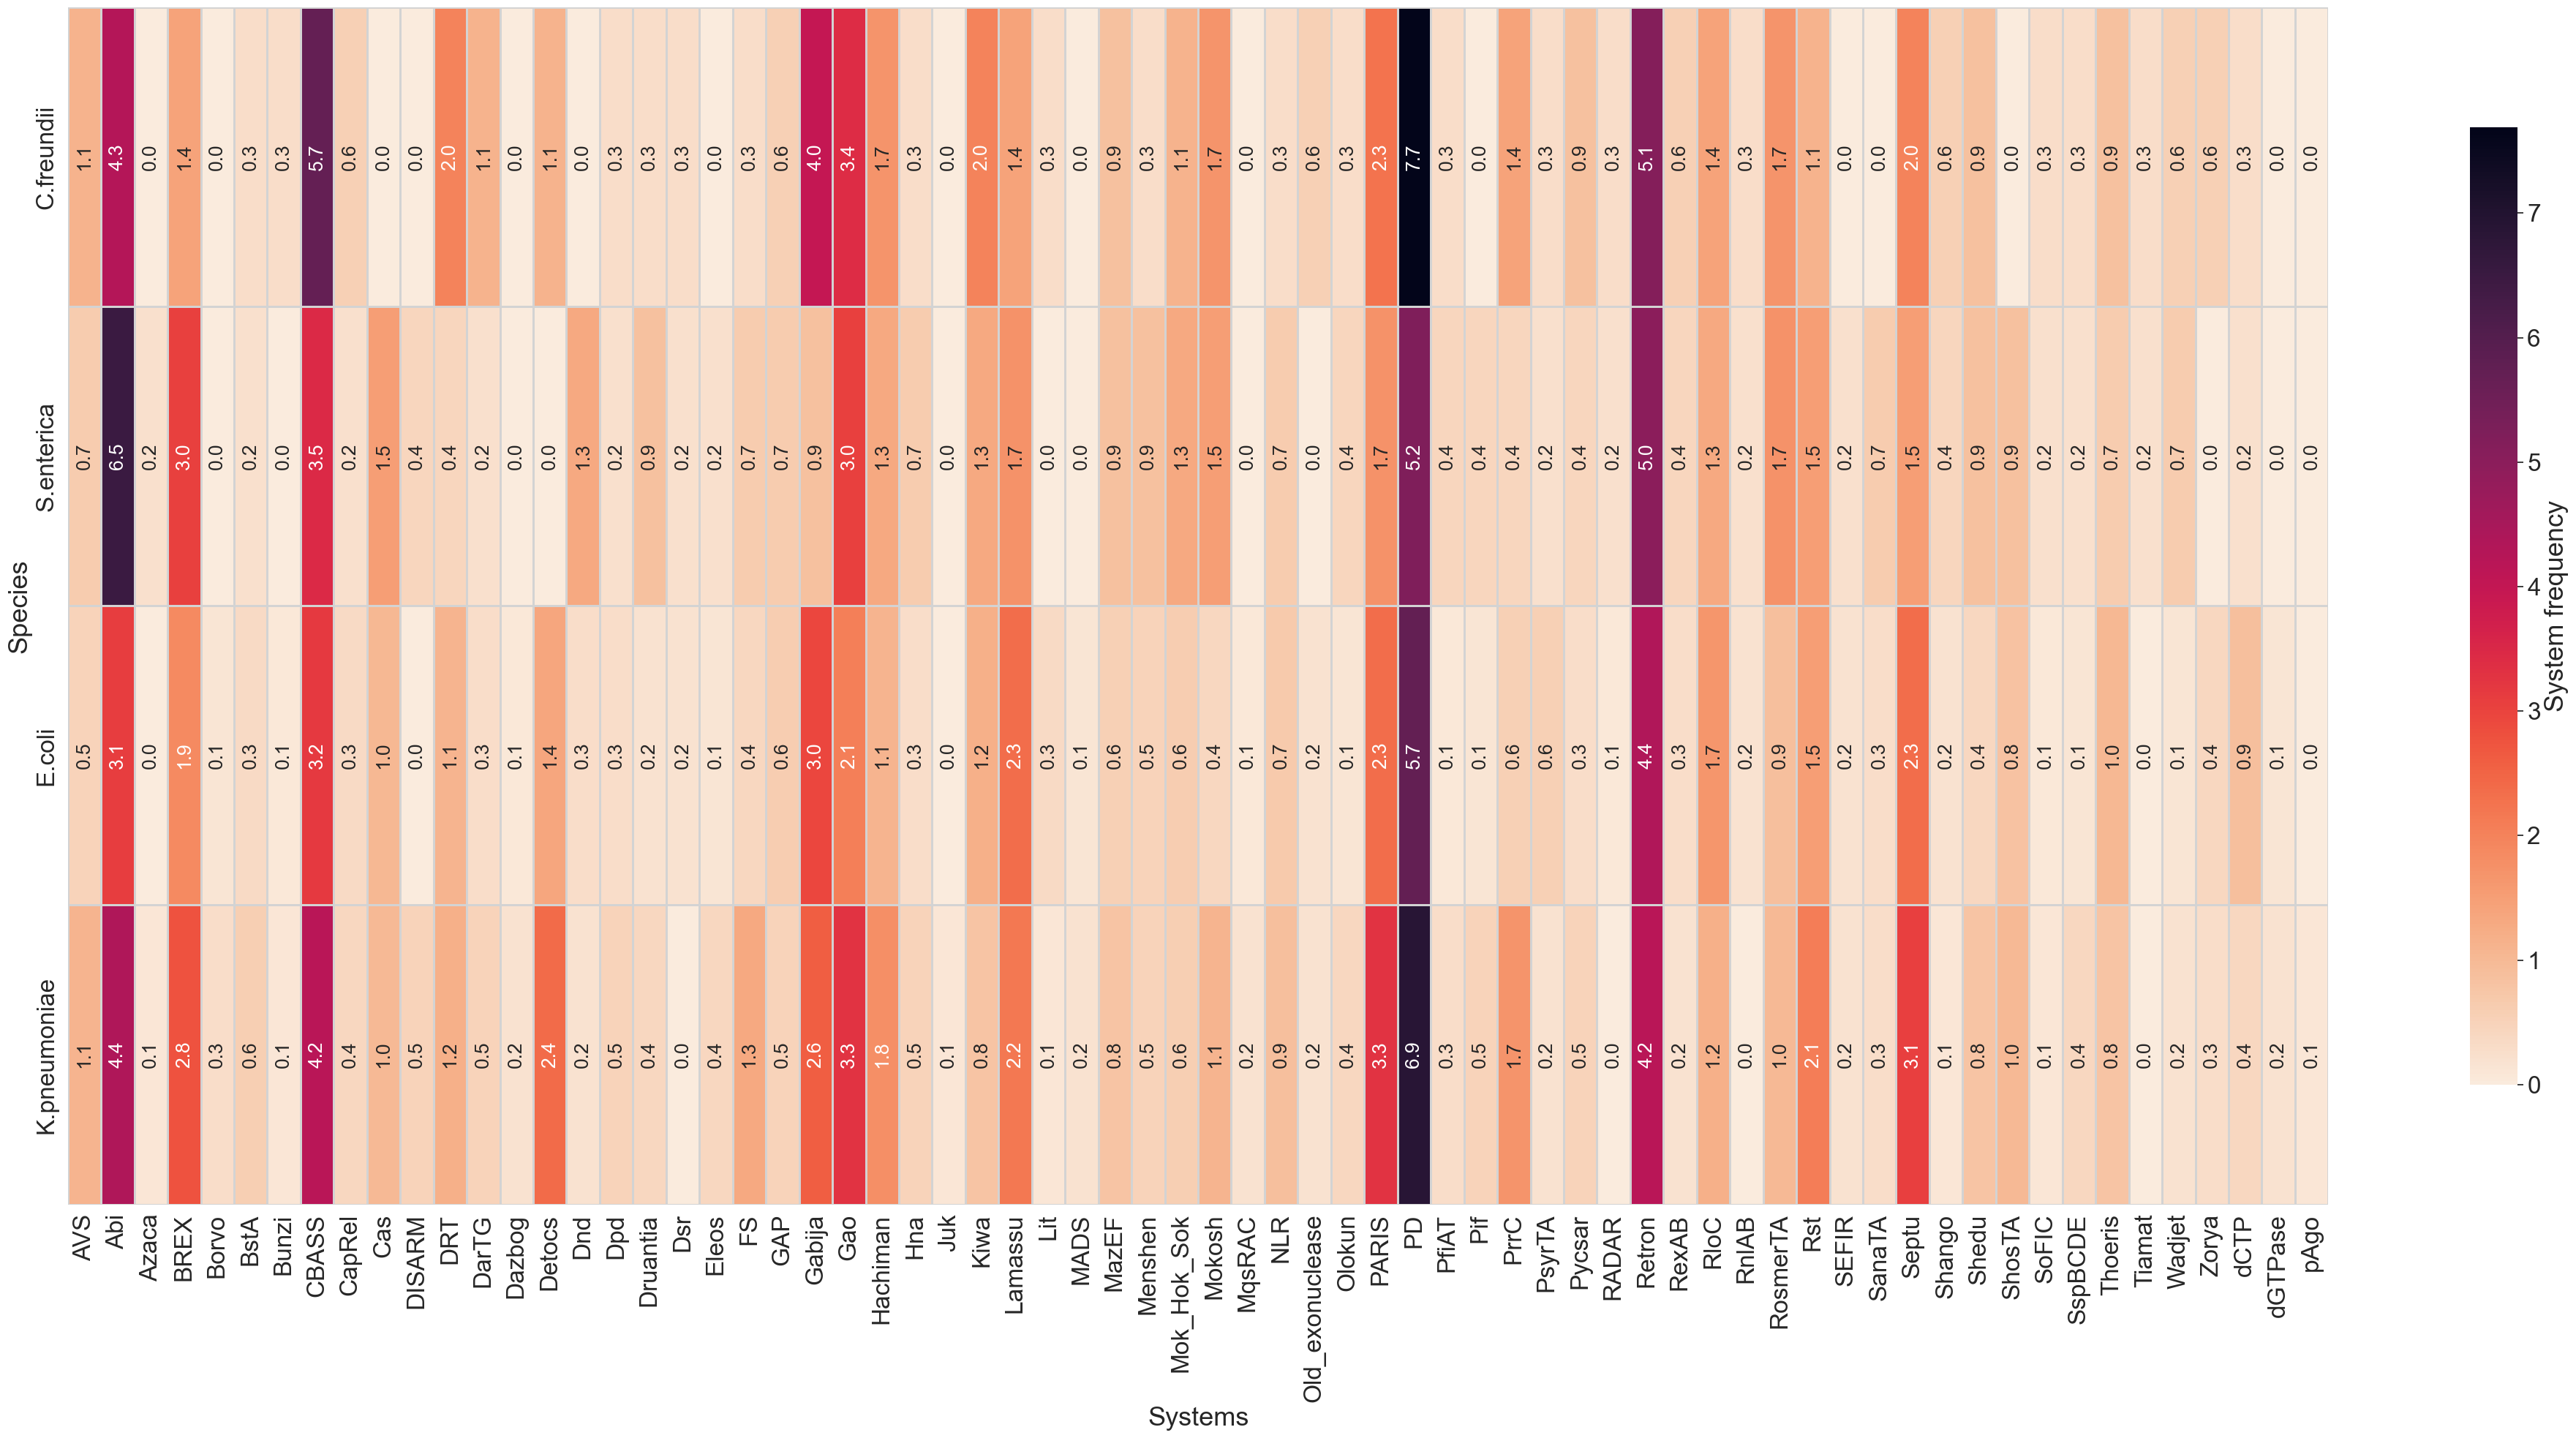

In [8]:
from sources.heatmap import load_system_data, generate_heatmap

data = load_system_data(ENTEROBACTERIACEAE)
params = {
    'linecolor': 'lightgray',
    'linewidths': 1,
    "cmap": 'rocket_r',
    "xticklabels": True,
    "yticklabels": True
}

# Generate heatmap for normalized system frequencies without RM
data_normalized = data.div(data.sum(axis=0), axis=1) * 100
data_normalized_no_rm = data_normalized.drop(index="RM")
generate_heatmap(
    data_normalized_no_rm,
    OUTPUT / "heatmap_normalized_sys_no_RM.png",
    figsize=FIGSIZE,
    cbar_label="System frequency",
    annot=True,
    fmt=".1f",
    **params
)

# # Calculate and plot system specificity
# col_sums = data.sum(axis=0).to_numpy()  # Sum by species (columns)
# row_sums = data.sum(axis=1).to_numpy()  # Sum by system (rows)
# total_sum = data.values.sum()  # Total sum
#
# # Calculate specificity metric
# specificity_data = (data.div(col_sums, axis=1)) / (row_sums / total_sum)[:, None]
# generate_heatmap(
# 	specificity_data,
# 	output / "heatmap_system_distribution.png",
# 	figsize=figsize,
# 	title="System Specificity Across Species",
# 	cbar_label="Specificity",
# 	annot=True,
# 	fmt=".1f",
# 	**common_params
# )


**Fig. 6. Relative frequency of system categories in Enterobacteriaceae pangenomes.** The relative frequencies are expressed as a percentage. The RM system category was removed to get a clearer view.

### Identification of conserved spots

/home/jarnoux/anaconda3/envs/panorama_notebook/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/jarnoux/anaconda3/envs/panorama_notebook/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

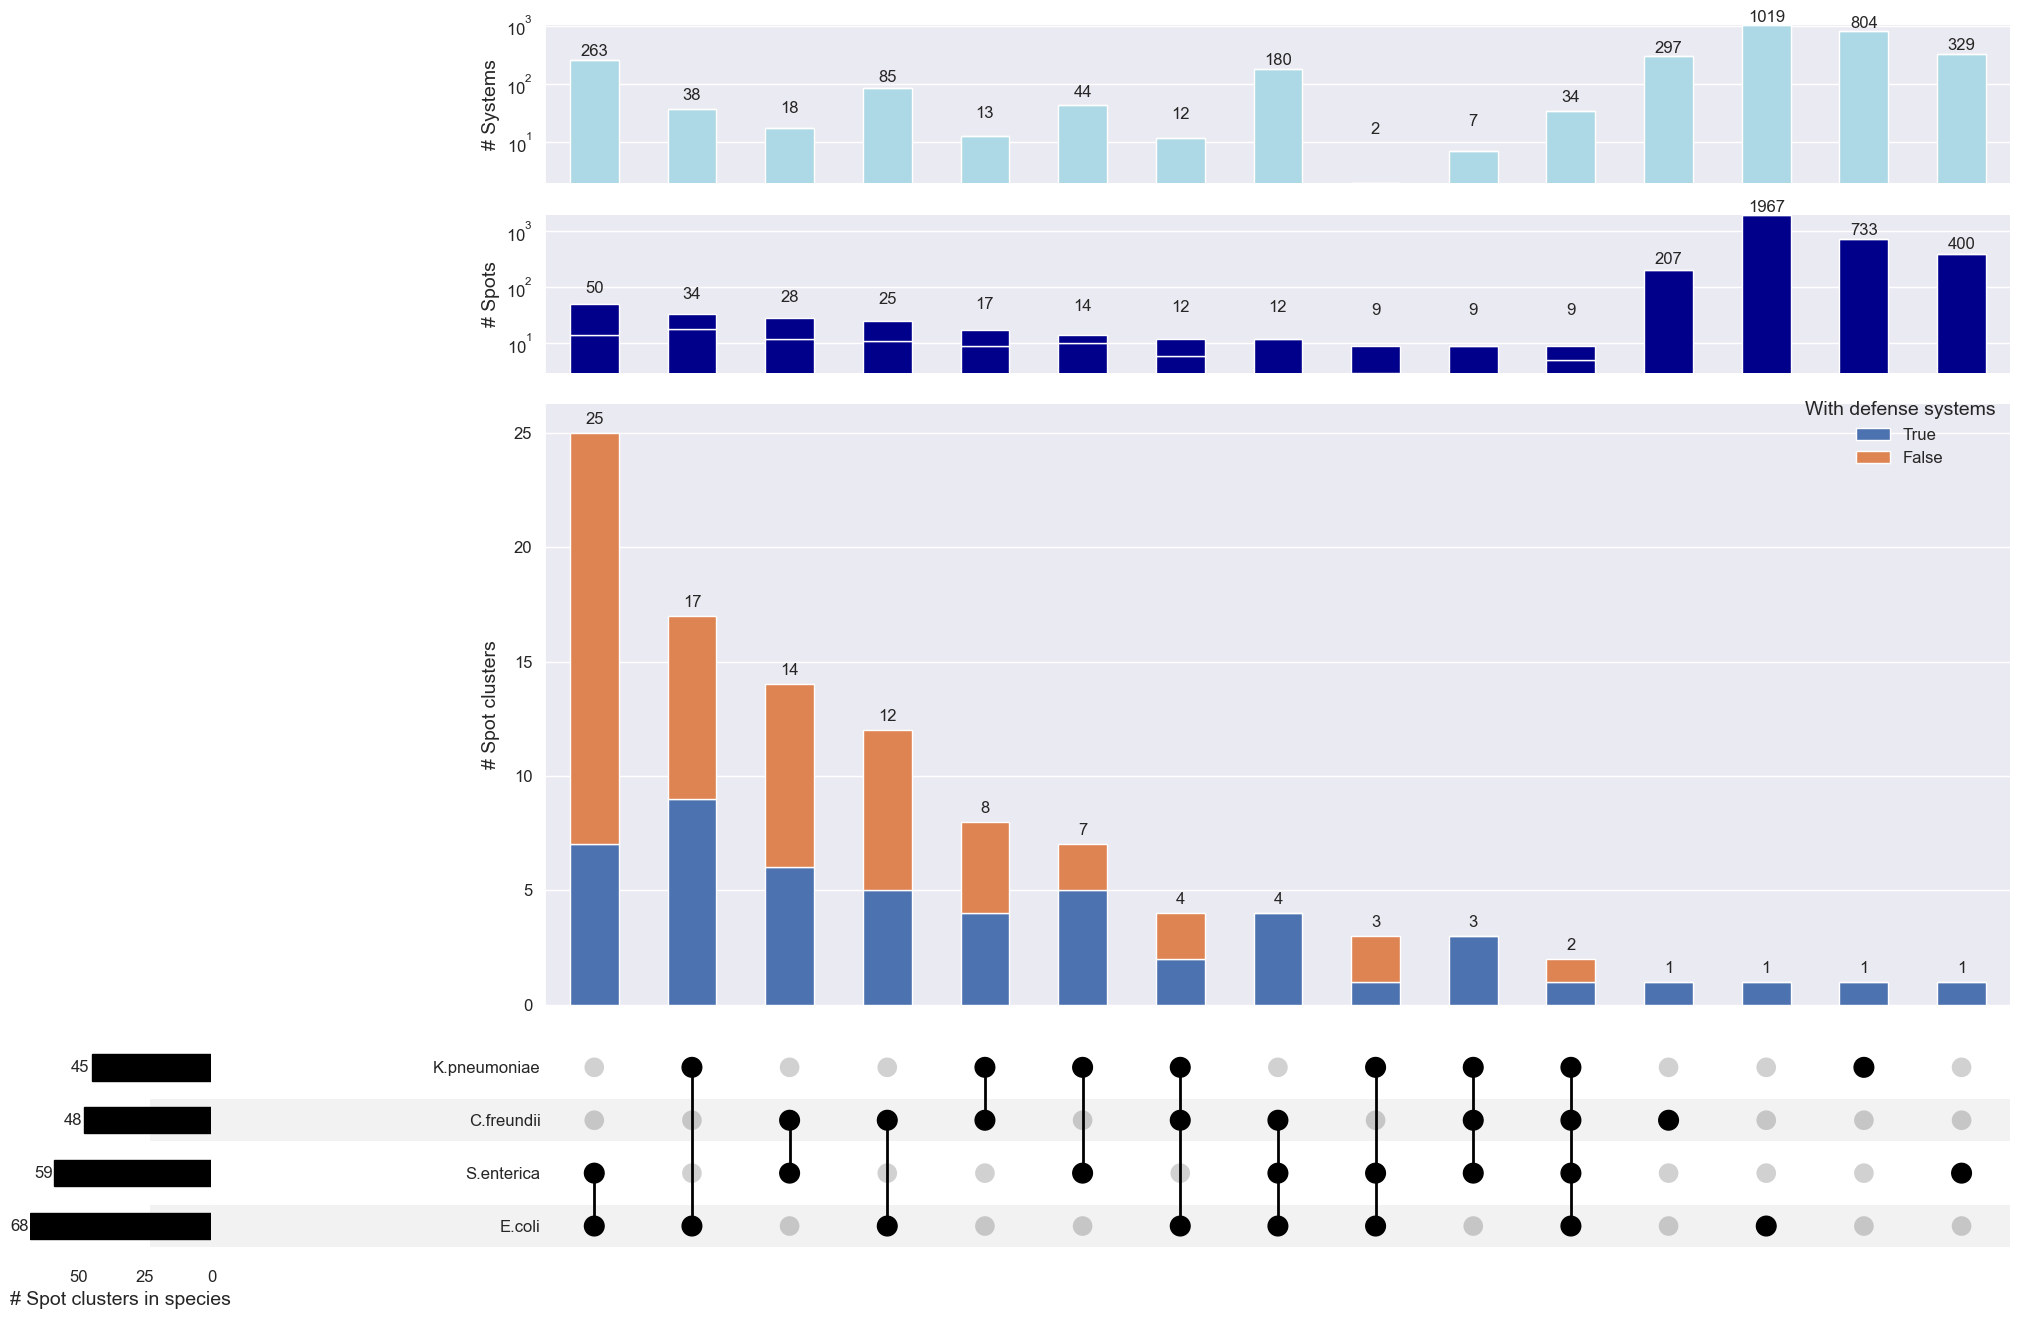

In [9]:
from sources.upset_plot import parse_data, generate_upset_plot_spots

# Example usage
cs_res = pd.read_csv(ENTEROBACTERIACEAE / "all_conserved_spots.tsv", sep="\t",
                     usecols=["Conserved ID", "Spot ID", "Pangenome"])

spots_data = {
    'C.freundii': 254,
    'E.coli': 2036,
    'K.pneumoniae': 778,
    'S.enterica': 458
}

systems_data = {
    'C.freundii': pd.read_csv(C_FREUNDII / "spot_to_systems.tsv", sep="\t",
                              usecols=["name", "systems_ID", "systems_name"]),
    'E.coli': pd.read_csv(E_COLI / "spot_to_systems.tsv", sep="\t",
                          usecols=["name", "systems_ID", "systems_name"]),
    'K.pneumoniae': pd.read_csv(K_PNEUMONIAE / "spot_to_systems.tsv", sep="\t",
                                usecols=["name", "systems_ID", "systems_name"]),
    'S.enterica': pd.read_csv(S_ENTERICA / "spot_to_systems.tsv", sep="\t",
                              usecols=["name", "systems_ID", "systems_name"])
}

parsed_data, pangenomes = parse_data(cs_res, systems_data)
generate_upset_plot_spots(cs_res, spots_data, systems_data, OUTPUT)



**Fig. 7. Sharing of spot clusters across four species and their association with defense systems.** The UpSet plot shows the number of spot clusters shared across the four compared species, with stacked bars to indicate whether they contain defense systems (in blue) or not (in orange). The two top bar plots represent spot and defense system abundance metrics on a logarithmic scale.

### Spot identification and conservation

/tmp/ipykernel_117352/1015027749.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spots_df = system_df.groupby("spots").apply(grouped_row).reset_index(drop=True)
/tmp/ipykernel_117352/1015027749.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spots_df = system_df.groupby("spots").apply(grouped_row).reset_index(drop=True)
/tmp/ipykernel_117352/1015027749.py:68: DeprecationWarning: DataFrameGroupBy.a

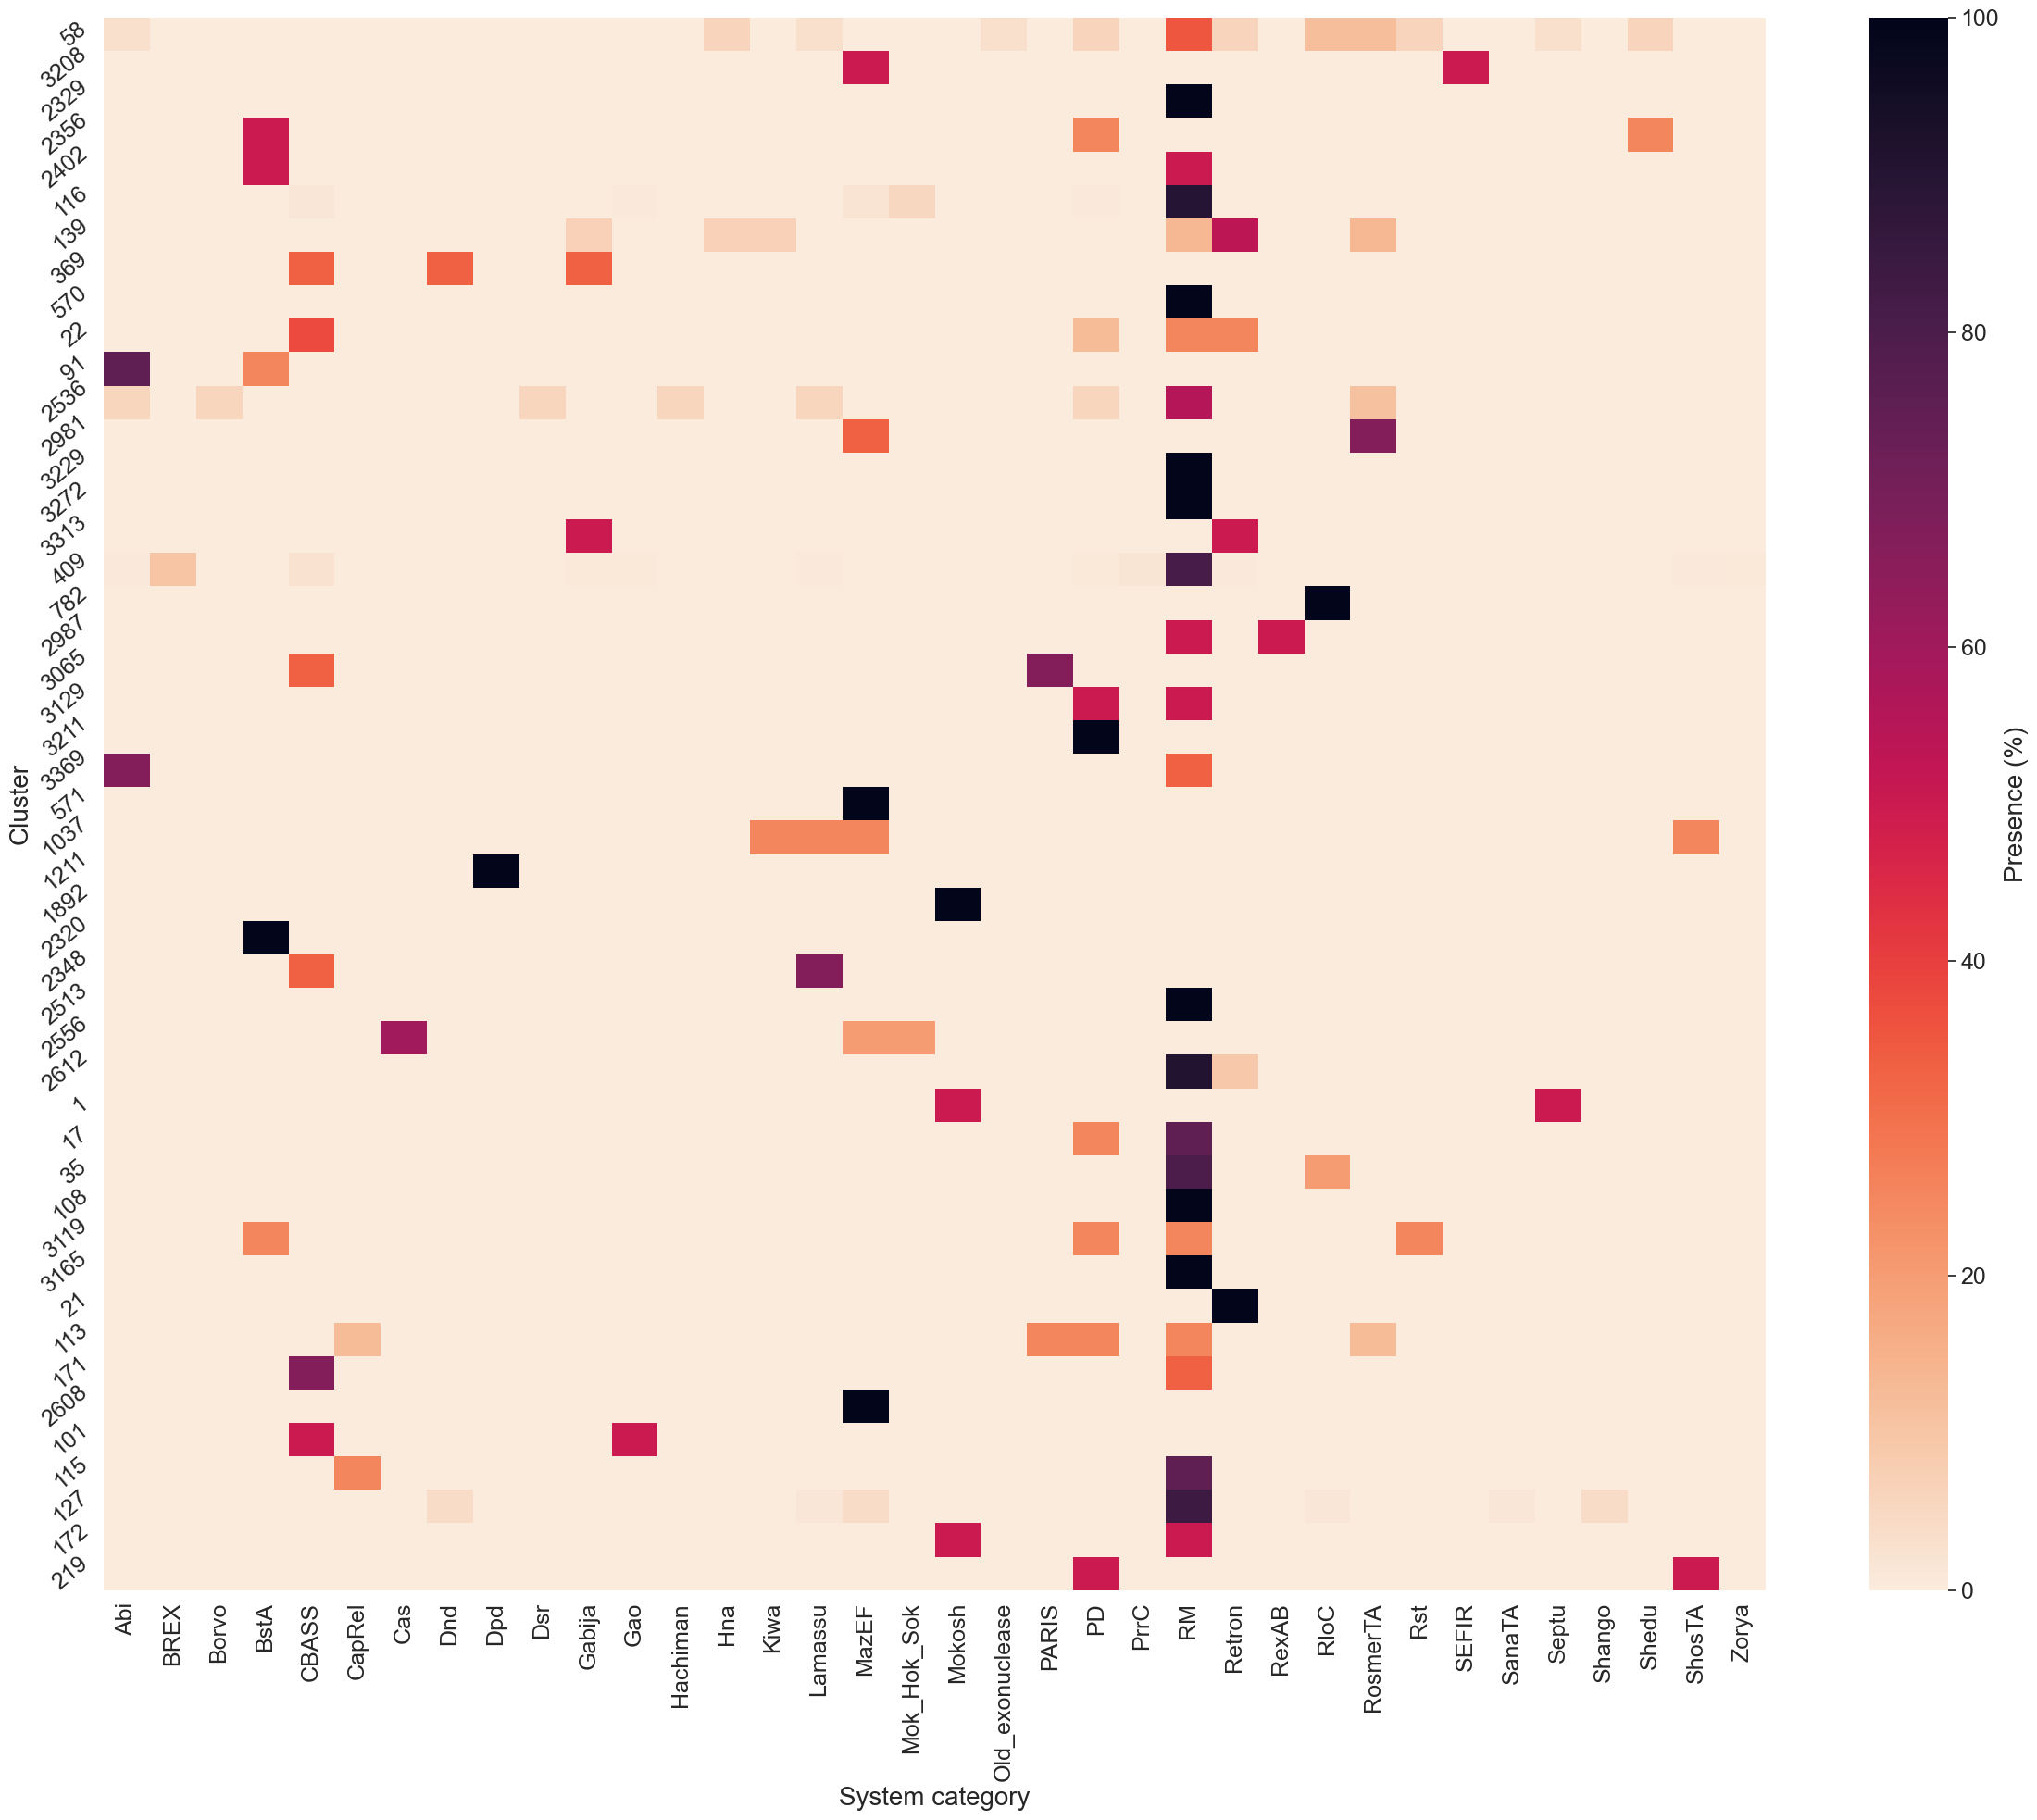

In [11]:
from sources.cs_link import parse_data, generate_tile_plot_visualization
results = pd.read_csv(ENTEROBACTERIACEAE / "all_conserved_spots.tsv", sep="\t",
                      usecols=["Conserved ID", "Spot ID", "Pangenome"])

systems_data = {
    'C.freundii': pd.read_csv(C_FREUNDII / "systems.tsv", sep="\t"),
    'E.coli': pd.read_csv(E_COLI / "systems.tsv", sep="\t"),
    'K.pneumoniae': pd.read_csv(K_PNEUMONIAE / "systems.tsv", sep="\t"),
    'S.enterica': pd.read_csv(S_ENTERICA / "systems.tsv", sep="\t")
}

data = parse_data(results, systems=systems_data)
data.to_csv(OUTPUT / "cs_link.tsv", sep="\t", index=True)
generate_tile_plot_visualization(data, OUTPUT)
